# SFM with BAL Files

This is an SFM Example that reads from a BAL (Bundle Adjustment in the Large) file.

In [1]:
%pip -q install gtsam==4.2a5

Note: you may need to restart the kernel to use updated packages.


In [2]:
import argparse
import logging
import sys

import gtsam
from gtsam import (GeneralSFMFactorCal3Bundler,
                   PriorFactorPinholeCameraCal3Bundler, PriorFactorPoint3)
from gtsam.symbol_shorthand import C, P  # type: ignore
from gtsam.utils import plot  # type: ignore
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

Run LM optimization with BAL input data and report resulting error:

In [4]:
# Load the SfM data from file
input_file = gtsam.findExampleDataFile("dubrovnik-3-7-pre")
scene_data = gtsam.readBal(input_file)
logging.info("read %d tracks on %d cameras\n", scene_data.numberTracks(),
                scene_data.numberCameras())

INFO:root:read 7 tracks on 3 cameras



In [5]:
# Create a factor graph
graph = gtsam.NonlinearFactorGraph()

# We share *one* noiseModel between all projection factors
noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

# Add measurements to the factor graph
for j in range(scene_data.numberTracks()):
    track = scene_data.track(j)  # SfmTrack
    # retrieve the SfmMeasurement objects
    for m_idx in range(track.numberMeasurements()):
        # i represents the camera index, and uv is the 2d measurement
        i, uv = track.measurement(m_idx)
        # note use of shorthand symbols C and P
        graph.add(GeneralSFMFactorCal3Bundler(uv, noise, C(i), P(j)))

# Add a prior on pose x1. This indirectly specifies where the origin is.
graph.push_back(
    PriorFactorPinholeCameraCal3Bundler(
        C(0), scene_data.camera(0),
        gtsam.noiseModel.Isotropic.Sigma(9, 0.1)))
# Also add a prior on the position of the first landmark to fix the scale
graph.push_back(
    PriorFactorPoint3(P(0),
                      scene_data.track(0).point3(),
                      gtsam.noiseModel.Isotropic.Sigma(3, 0.1)))

In [6]:
# Create initial estimate
initial = gtsam.Values()

i = 0
# add each PinholeCameraCal3Bundler
for cam_idx in range(scene_data.numberCameras()):
    camera = scene_data.camera(cam_idx)
    initial.insert(C(i), camera)
    i += 1

# add each SfmTrack
for j in range(scene_data.numberTracks()):
    track = scene_data.track(j)
    initial.insert(P(j), track.point3())

In [7]:
# Optimize the graph and print results
try:
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosityLM("ERROR")
    lm = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
    result = lm.optimize()
    # Error drops from ~2764.22 to ~0.046
    logging.info("initial error: %f", graph.error(initial))
    logging.info("final error: %f", graph.error(result))

except RuntimeError:
    logging.exception("LM Optimization failed")


INFO:root:initial error: 2764.219293
INFO:root:final error: 0.046138


Plot the SFM results.

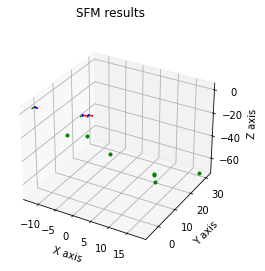

In [8]:
plot_vals = gtsam.Values()
for cam_idx in range(scene_data.numberCameras()):
    plot_vals.insert(C(cam_idx),
                        result.atPinholeCameraCal3Bundler(C(cam_idx)).pose())
for j in range(scene_data.numberTracks()):
    plot_vals.insert(P(j), result.atPoint3(P(j)))

plot.plot_3d_points(0, plot_vals, linespec="g.")
plot.plot_trajectory(0, plot_vals, title="SFM results")

plt.show()